In [1]:
import numpy as np
import os
from model import SignDetection
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
DATA_PATH=os.path.join('data','final')
LOG_PATH=os.path.join('logs')
MODEL_PATH=os.path.join('model')

In [5]:
X_train=torch.from_numpy(np.load(os.path.join(DATA_PATH,'X_train.npy'))).type(torch.FloatTensor).to(device)
y_train=torch.from_numpy(np.load(os.path.join(DATA_PATH,'y_train.npy'))).type(torch.FloatTensor).to(device)

X_test=torch.from_numpy(np.load(os.path.join(DATA_PATH,'X_test.npy'))).type(torch.FloatTensor).to(device)
y_test=torch.from_numpy(np.load(os.path.join(DATA_PATH,'y_test.npy'))).type(torch.FloatTensor).to(device)

In [6]:
print(X_train.shape)
print(y_train.shape)

torch.Size([142, 30, 126])
torch.Size([142, 5])


In [7]:
torch.manual_seed(42)
signs=SignDetection()
signs.to(device)

SignDetection(
  (lstm1): LSTM(126, 128, batch_first=True)
  (lstm2): LSTM(128, 64, batch_first=True)
  (lstm3): LSTM(64, 64, batch_first=True)
  (linear1): Linear(in_features=64, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=5, bias=True)
)

In [8]:
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(signs.parameters(), lr=1e-5)

In [9]:
def accuracy_function(y_pred, y_act):
    correct=(torch.argmax(y_pred,dim=1)==torch.argmax(y_act,dim=1)).sum()
    return correct.item()/len(y_pred)

In [10]:
epochs=2000

In [11]:
writer=SummaryWriter(log_dir=LOG_PATH)
epoch_losses=[]
epoch_accuracy=[]
epoch_testlosses=[]
epoch_testaccuracy=[]
for e in range(epochs):
    signs.train()
    loss=0
    y_pred=signs(X_train)
    loss=criterion(y_pred,y_train)
    acc=accuracy_function(y_pred, y_train)
    writer.add_scalar("Loss/train", loss, e)
    writer.add_scalar("Accuracy/train", acc, e)
    writer.add_scalar("Learning rate", optimizer.param_groups[0]['lr'], e)
    epoch_losses.append(loss.item())
    epoch_accuracy.append(acc)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e+1)%500==0:
        print(f'For training epoch {e+1}\tLoss: {loss.item()}\tAccuracy:{acc}')
    
    signs.eval()
    with torch.no_grad():
        loss=0
        y_pred=signs(X_test)
        testloss=criterion(y_pred,y_test)
        testacc=accuracy_function(y_pred, y_test)
        writer.add_scalar("Loss/test", testloss,e)
        writer.add_scalar("Accuracy/test", testacc, e)
        epoch_testlosses.append(testloss.item())
        epoch_testaccuracy.append(testacc)
        if (e+1)%250==0:
            print(f'For testing: epoch {e+1}\tLoss: {testloss.item()}\tAccuracy:{testacc}\n')
    optimizer.param_groups[0]['lr'] *=.99997
    

For testing: epoch 250	Loss: 1.607824444770813	Accuracy:0.125

For training epoch 500	Loss: 1.5971062183380127	Accuracy:0.4014084507042254
For testing: epoch 500	Loss: 1.595491886138916	Accuracy:0.375

For testing: epoch 750	Loss: 1.5451958179473877	Accuracy:0.375

For training epoch 1000	Loss: 1.4361960887908936	Accuracy:0.6056338028169014
For testing: epoch 1000	Loss: 1.452359676361084	Accuracy:0.5

For testing: epoch 1250	Loss: 1.388156533241272	Accuracy:0.625

For training epoch 1500	Loss: 1.2539644241333008	Accuracy:0.8028169014084507
For testing: epoch 1500	Loss: 1.321969985961914	Accuracy:0.625

For testing: epoch 1750	Loss: 1.2774860858917236	Accuracy:0.75

For training epoch 2000	Loss: 1.1198008060455322	Accuracy:0.9929577464788732
For testing: epoch 2000	Loss: 1.2451469898223877	Accuracy:0.75



In [12]:
torch.save(signs,os.path.join(MODEL_PATH,'model','model_'+str(epochs)+'.pt'))
torch.save(signs.state_dict(), os.path.join(MODEL_PATH,'model_state_dicts','model_'+str(epochs)+'.pt'))

## Testing on test set

In [13]:
import matplotlib.pyplot as plt

#### 1. Checking accuracy on the train set
This will help us understand which actions is the model finding it difficult to predict even on the data it is trained on

In [14]:
X_train=torch.from_numpy(np.load(os.path.join(DATA_PATH,'X_train.npy'))).type(torch.FloatTensor).to(device)
y_train=torch.from_numpy(np.load(os.path.join(DATA_PATH,'y_train.npy'))).type(torch.FloatTensor).to(device)

In [15]:
actions=['ascend', 'descend', 'ok', 'not ok','stop']

In [16]:
model_names=os.listdir(os.path.join(MODEL_PATH,'model'))
model_names

['model_1000.pt',
 'model_2000.pt',
 'model_3000.pt',
 'model_4000.pt',
 'model_5000.pt']

In [17]:
def get_confusion_matrix(y_test,y_pred):
    conf_matrix=confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title('Confusion Matrix', fontsize=12)
    plt.show()

******************Testing  model_1000 ******************
Mismatches
{('ascend', 'descend'): 25, ('stop', 'not ok'): 26, ('ok', 'descend'): 3, ('ok', 'not ok'): 2}


Accuracy:	 60.56338028169014 %




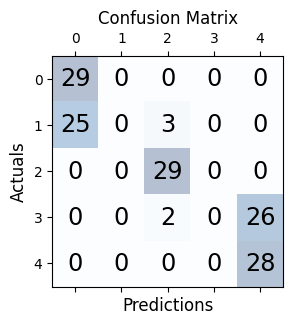

              precision    recall  f1-score   support

           0       0.54      1.00      0.70        29
           1       0.00      0.00      0.00        28
           2       0.85      1.00      0.92        29
           3       0.00      0.00      0.00        28
           4       0.52      1.00      0.68        28

    accuracy                           0.61       142
   macro avg       0.38      0.60      0.46       142
weighted avg       0.39      0.61      0.47       142



******************Testing  model_2000 ******************
Mismatches
{('ascend', 'descend'): 1}


Accuracy:	 99.29577464788733 %




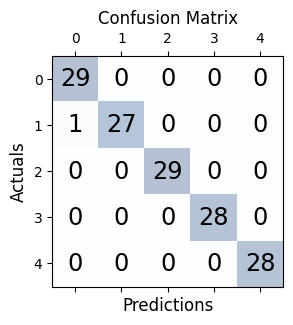

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        29
           1       1.00      0.96      0.98        28
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        28

    accuracy                           0.99       142
   macro avg       0.99      0.99      0.99       142
weighted avg       0.99      0.99      0.99       142



******************Testing  model_3000 ******************
Mismatches
{}


Accuracy:	 100.0 %




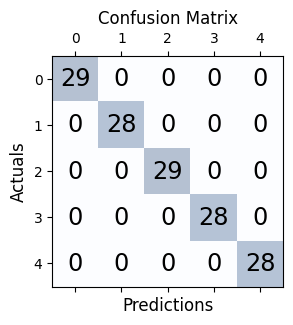

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        28

    accuracy                           1.00       142
   macro avg       1.00      1.00      1.00       142
weighted avg       1.00      1.00      1.00       142



******************Testing  model_4000 ******************
Mismatches
{}


Accuracy:	 100.0 %




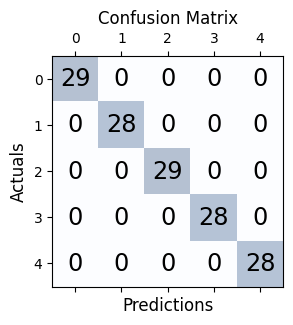

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        28

    accuracy                           1.00       142
   macro avg       1.00      1.00      1.00       142
weighted avg       1.00      1.00      1.00       142



******************Testing  model_5000 ******************
Mismatches
{}


Accuracy:	 100.0 %




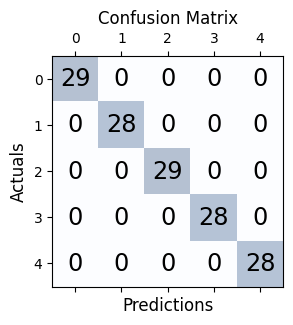

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00        28
           2       1.00      1.00      1.00        29
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        28

    accuracy                           1.00       142
   macro avg       1.00      1.00      1.00       142
weighted avg       1.00      1.00      1.00       142





In [18]:
for modelname in model_names:
    mismatches=[]
    dict_mismatches={}
    print('******************Testing ',modelname.split('.')[0],'******************')
    test_model=torch.load(os.path.join(MODEL_PATH,'model',modelname))
    y_train_pred=torch.argmax(test_model(X_train),dim=1).cpu().detach().numpy()
    y_train_real=torch.argmax(y_train,dim=1).cpu().detach().numpy()
    for i in range(len(y_train_pred)):
        if y_train_pred[i]==y_train_real[i]:
            continue
        else:
            mismatches.append((actions[y_train_pred[i]],actions[y_train_real[i]]))
    for m in mismatches:
        if m in dict_mismatches:
            dict_mismatches[m]+=1
        else:
            dict_mismatches[m]=1
    print('Mismatches')
    print(dict_mismatches)
    print('\n')
    acc=(y_train_pred==y_train_real).sum()/len(y_train_pred)
    print('Accuracy:\t',acc.item()*100,'%')
    print('\n')
    get_confusion_matrix(y_train_real,y_train_pred)
    print(classification_report(y_train_real,y_train_pred,zero_division=0))
    print('\n')

<ul><li>For the 2000 epoch model, it recognized action 1 as action 0 i.e. 'Descend' as 'Ascend'</li>

#### 2. Testing on the test set 

In [19]:
X_test=torch.from_numpy(np.load(os.path.join(DATA_PATH,'X_test.npy'))).type(torch.FloatTensor).to(device)
y_test=torch.from_numpy(np.load(os.path.join(DATA_PATH,'y_test.npy'))).type(torch.FloatTensor).to(device)

In [20]:
models=os.listdir(os.path.join(MODEL_PATH,'model'))
models

['model_1000.pt',
 'model_2000.pt',
 'model_3000.pt',
 'model_4000.pt',
 'model_5000.pt']

******************Testing  model_1000 ******************

Predicted ['ok', 'ascend', 'stop', 'stop', 'ascend', 'ascend', 'stop', 'stop']
Actual	 ['ok', 'ascend', 'stop', 'stop', 'descend', 'descend', 'not ok', 'not ok']


Accuracy:	 50.0 %




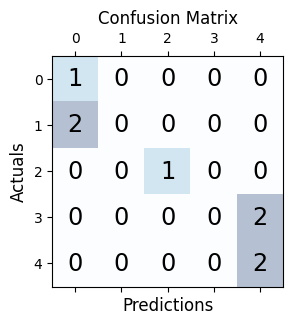

              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         2
           4       0.50      1.00      0.67         2

    accuracy                           0.50         8
   macro avg       0.37      0.60      0.43         8
weighted avg       0.29      0.50      0.35         8



******************Testing  model_2000 ******************

Predicted ['not ok', 'ascend', 'stop', 'stop', 'descend', 'ascend', 'not ok', 'not ok']
Actual	 ['ok', 'ascend', 'stop', 'stop', 'descend', 'descend', 'not ok', 'not ok']


Accuracy:	 75.0 %




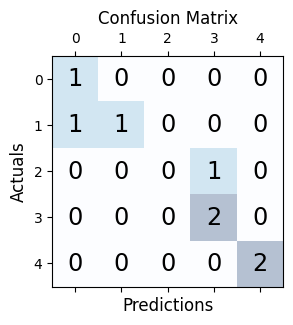

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      0.50      0.67         2
           2       0.00      0.00      0.00         1
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         2

    accuracy                           0.75         8
   macro avg       0.63      0.70      0.63         8
weighted avg       0.73      0.75      0.70         8



******************Testing  model_3000 ******************

Predicted ['not ok', 'ascend', 'stop', 'stop', 'descend', 'descend', 'not ok', 'not ok']
Actual	 ['ok', 'ascend', 'stop', 'stop', 'descend', 'descend', 'not ok', 'not ok']


Accuracy:	 87.5 %




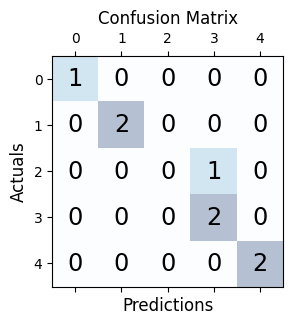

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       0.00      0.00      0.00         1
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         2

    accuracy                           0.88         8
   macro avg       0.73      0.80      0.76         8
weighted avg       0.79      0.88      0.82         8



******************Testing  model_4000 ******************

Predicted ['not ok', 'ascend', 'stop', 'stop', 'descend', 'descend', 'not ok', 'not ok']
Actual	 ['ok', 'ascend', 'stop', 'stop', 'descend', 'descend', 'not ok', 'not ok']


Accuracy:	 87.5 %




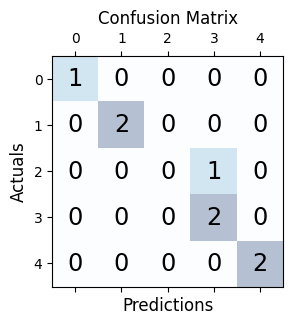

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       0.00      0.00      0.00         1
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         2

    accuracy                           0.88         8
   macro avg       0.73      0.80      0.76         8
weighted avg       0.79      0.88      0.82         8



******************Testing  model_5000 ******************

Predicted ['not ok', 'ascend', 'stop', 'stop', 'descend', 'descend', 'not ok', 'not ok']
Actual	 ['ok', 'ascend', 'stop', 'stop', 'descend', 'descend', 'not ok', 'not ok']


Accuracy:	 87.5 %




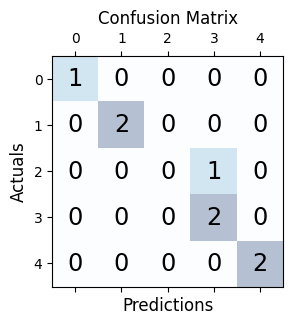

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         2
           2       0.00      0.00      0.00         1
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         2

    accuracy                           0.88         8
   macro avg       0.73      0.80      0.76         8
weighted avg       0.79      0.88      0.82         8





In [21]:
for modelname in models:
    print('******************Testing ',modelname.split('.')[0],'******************')
    test_model=torch.load(os.path.join(MODEL_PATH,'model',modelname))
    y_test_pred=torch.argmax(test_model(X_test),dim=1).cpu().detach().numpy()
    y_test_real=torch.argmax(y_test,dim=1).cpu().detach().numpy()
    print()
    print('Predicted' , [actions[x] for x in list(y_test_pred)])
    print('Actual\t', [actions[x] for x in list(y_test_real)])
    print('\n')
    acc=(y_test_pred==y_test_real).sum()/len(y_pred)
    print('Accuracy:\t',acc.item()*100,'%')
    print('\n')
    get_confusion_matrix(y_test_real,y_test_pred)
    print(classification_report(y_test_real,y_test_pred,zero_division=0))
    print('\n')

<ul>
    <li>So, across all models, action 2 is predicted as action 3 i.e. 'OK' is being recognized as 'not OK. </li>
    <li>For the 2000 epoch model, it also recognized action 1 as action 0 i.e. 'Descend' as 'Ascend'</li>
    <li>However, all 'not OK' actions are being recognized correctly for all models </li>